# Intro

This notebook compares sample reviews from Capterra with competitors' reviews from the perspective of someone at 'Accelo' (a piece of software chosen at random). The reviews in this study were made up of the following quantities:
*   Accelo: https://www.capterra.co.nz/reviews/135686/accelo (129)
*   GreenRope: https://www.capterra.co.nz/reviews/130598/greenrope (138)
*   NiceJob: https://www.capterra.co.nz/reviews/142037/nicejob (60)

The data from these reviews include the following data points:
 - title
 - date
 - overall stars (/5)
 - ease of use (/5)
 - customer support (/5)
 - features (/5)
 - value (/5)
 - likelihood to recommend (/10)
 - comments (text)
 - pros (text)
 - cons (text)

In this example, the data was stored in .jl files.

# Load Data

Sample data was scraped off Capterra and saved in json lines (.jl) files.

Examples of the final data are shown in the output below.

In [131]:
#@title
# To run this notebook, upload the data sets for each of the companies in the order below

import json
import pandas as pd
import numpy as np
import re
from datetime import datetime, timedelta

companies = [('Accelo', '/Users/sam/Documents/projects/Scrapy/reviews/accelo.jl'),
             ('GreenRope', '/Users/sam/Documents/projects/Scrapy/reviews/greenrope.jl'),
             ('NiceJob', '/Users/sam/Documents/projects/Scrapy/reviews/nicejob.jl')]

IS_MAIN_COMPANY = 'is_accelo'
MAIN_COMPANY_NAME = 'Accelo'
OTHER_COMPANY_NAMES = 'Others (GreenRope, NiceJob)'

# from google.colab import files # if using Google Colaboratory
# import io
# uploaded = files.upload()
# data = pd.read_json(uploaded[file], lines=True, orient='columns', encoding='utf-8')
# data = pd.read_csv(io.StringIO(uploaded[file].decode('utf-8'))) # for csv

reviews = []

# Open each file in turn
for (name, file) in companies:
  data = []
  with open(file) as f:
    for line in f:
        data.append(json.loads(line))

  # Load reviews into dataframe
  for x in data:
      review = {}
      review['title'] = x['title'] if type(x['title'] == 'str') else None
      review['date'] = datetime.strptime(x['date'], 'Reviewed on %d/%m/%Y')
      review['overall-stars'] = int(re.findall('\d+', x['overall-stars'])[0]) if x['overall-stars'] else None
      review['ease-of-use'] = int(re.findall('\d+', x['ease-of-use'])[0]) if x['ease-of-use'] else None
      review['customer-support'] = int(re.findall('\d+', x['customer-support'])[0]) if x['customer-support'] else None
      review['features'] = int(re.findall('\d+', x['features'])[0]) if x['features'] else None
      review['value'] = int(re.findall('\d+', x['value'])[0]) if x['value'] else None
      review['likelihood'] = int(re.search('/capterra/images/reviews/gauge-(\d+).*',x['likelihood']).group(1)) if x['likelihood'] else None
      review['comments'] = x['comments'] if x['comments'] != np.NaN else ''
      review['pros'] = x['pros'] if x['pros'] else ''
      review['cons'] = x['cons'] if x['cons'] else ''
      review['company'] = name

      # Only include reviews that have a title
      if review['title']:
          reviews.append(review)

# Tidy up dataframe
df = pd.DataFrame(reviews)
df['comments'] = df['comments'].fillna('')
df = df.sort_values(by='date').reset_index()
df[IS_MAIN_COMPANY] = np.where(df["company"]==MAIN_COMPANY_NAME, MAIN_COMPANY_NAME, OTHER_COMPANY_NAMES)
df.tail(2)

,index,title,date,overall-stars,ease-of-use,customer-support,features,value,likelihood,comments,pros,cons,company,is_accelo
73,11,The Best CRM!,2019-11-06,5,5,5.0,5.0,5.0,10.0,We've centralized several different services i...,"Ease of use, completely customizable, thoughtf...",I wish I would have found it so much earlier t...,Accelo,Accelo
74,37,The Greenrope Team ROCKS!,2019-11-09,5,5,5.0,5.0,5.0,10.0,VERY POSITIVE. The best part about this is the...,"A ton, the organization of elements, I also li...","Nothing, I am new to GR so alot of my problems...",GreenRope,"Others (GreenRope, NiceJob)"


# Data Set

There were 25 reviews for Accelo; these were to be compared against a total of 50 reviews for the other two companies combined.

In [132]:
#@title
company_counts = df['company'].value_counts()
company_counts

Accelo       25
NiceJob      25
GreenRope    25
Name: company, dtype: int64

# Descriptive Statistics

## Overall Ratings

The Accelo reviews had a median overall rating of 4/5 stars, which was less than GreenRope and NiceJob, which both had median reviews of 5/5.  

In [133]:
#@title
df.groupby(df.company)[['overall-stars']].median()

,overall-stars
company,
Accelo,4
GreenRope,5
NiceJob,5


Accelo also had a higher proportion of negative reviews than most of the companies in the study, as can be seen from the boxplots below (one company had so little variation that the 'box' in their boxplot shows as just a straight line): 

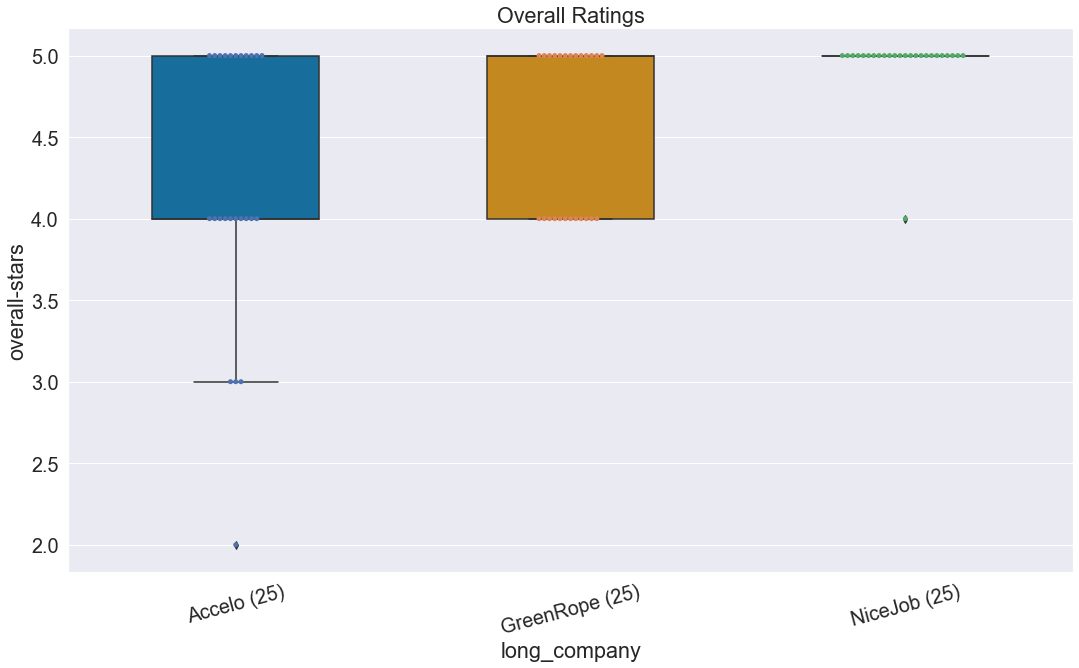

In [134]:
#@title
import seaborn as sns

# Reformat company name to include count of reviews
long_company = []
for i, row in df.iterrows():
    name = row['company'] + " (" + str(company_counts[row['company']]) + ")"
    long_company.append(name)  
df['long_company'] = long_company

# Box plot of overall ratings frequencies, possible values 1 to 5
sns.set(font_scale=1.8,rc={'figure.figsize':(18,10)})
ax = sns.boxplot(x='long_company',
                 y='overall-stars', 
                 data=df, 
                 width=0.5,
                 palette="colorblind")
ax.set(xlabel='',ylabel='Overall Rating', title="Overall Ratings")
ax.set_xticklabels(ax.get_xticklabels(),rotation=15)
ax = sns.swarmplot(x='long_company',
                   y='overall-stars', 
                   data=df)

The following boxplot compares the Accelo ratings to all of the competitors grouped together.

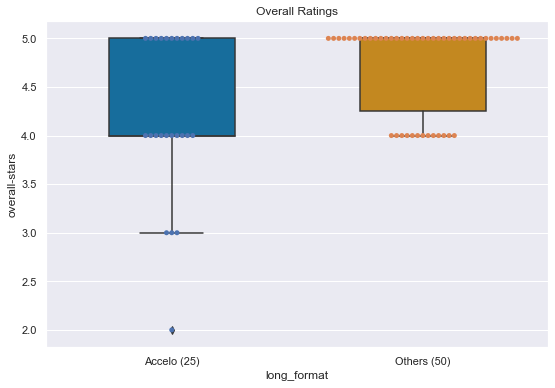

In [135]:
#@title
# Reformat company name to include count of reviews
count_others = company_counts.sum() - company_counts[MAIN_COMPANY_NAME]
long_format = []
for i, row in df.iterrows():
    if row[IS_MAIN_COMPANY] == MAIN_COMPANY_NAME:
        name = MAIN_COMPANY_NAME + " (" + str(company_counts[row['company']]) + ")"
    else:
        name = "Others (" + str(count_others) + ")"
    long_format.append(name)  
df['long_format'] = long_format

# Box plot of overall ratings frequencies, possible values 1 to 5
sns.set(rc={'figure.figsize':(9,6)})
bplot = sns.boxplot(x='long_format',
                 y='overall-stars', 
                 data=df, 
                 width=0.5,
                 palette="colorblind").set(xlabel='',title="Overall Ratings")
ax = sns.swarmplot(x='long_format',
                   y='overall-stars', 
                   data=df)

Again, when comparing the breakdown of Accelo ratings against competitor rankings, it is clear that competitors overall had a much heavier concentration of 5/5 ratings, as well as no 2/5 and 3/5 ratings:

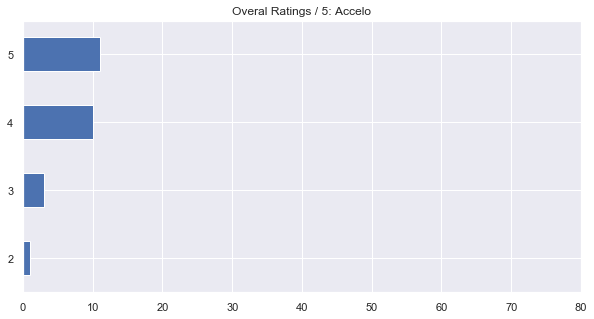

In [136]:
#@title
# Bar chart of overall main company ratings
df[df[IS_MAIN_COMPANY]==MAIN_COMPANY_NAME]['overall-stars'].value_counts() \
    .sort_index().plot(kind='barh',figsize=(10,5),xlim=[0, 80], \
                       title="Overal Ratings / 5: " + MAIN_COMPANY_NAME)

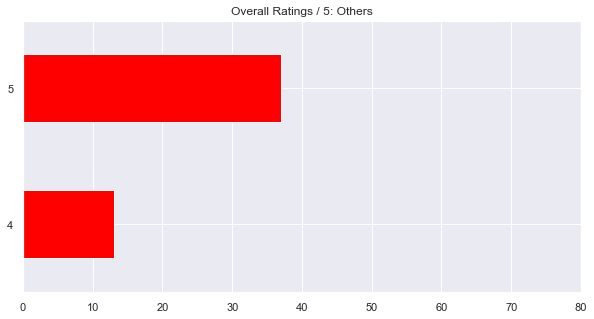

In [138]:
#@title
# Bar chart of overall non-main company ratings
df[df[IS_MAIN_COMPANY]!=MAIN_COMPANY_NAME]['overall-stars'].value_counts() \
    .sort_index().plot(kind='barh',figsize=(10,5),color="red",xlim=[0, 80], \
                       title="Overall Ratings / 5: Others")

In fact, over 95% of reviews for NiceJob were 5/5, as well as 50%+ for GreenRope. In contrast, under 45% of Accelo reviews were 5/5.

In [140]:
#@title
five_counts = df[df['overall-stars']==5]['company'].value_counts()
all_counts = df['company'].value_counts()
fives_ratio_df = pd.DataFrame(dict(five_counts = five_counts.astype('Int64'), all_counts = all_counts)).reset_index()
fives_ratio_df.fillna(0, inplace=True)
fives_ratio_df['percent'] = round(fives_ratio_df['five_counts']/fives_ratio_df['all_counts'] * 100,1)
fives_ratio_df

,index,five_counts,all_counts,percent
0,Accelo,11,25,44.0
1,GreenRope,13,25,52.0
2,NiceJob,24,25,96.0


## Metric Breakdowns: Accelo vs. Combined

The chart below reports the means for the numeric data fields in the reviews: likelihood to recommend, overall rating, value, features, customer support, and ease of use.

The score for likelihood to recommend has been halved from (/10) in order to align with the scale for the other metrics (/5).

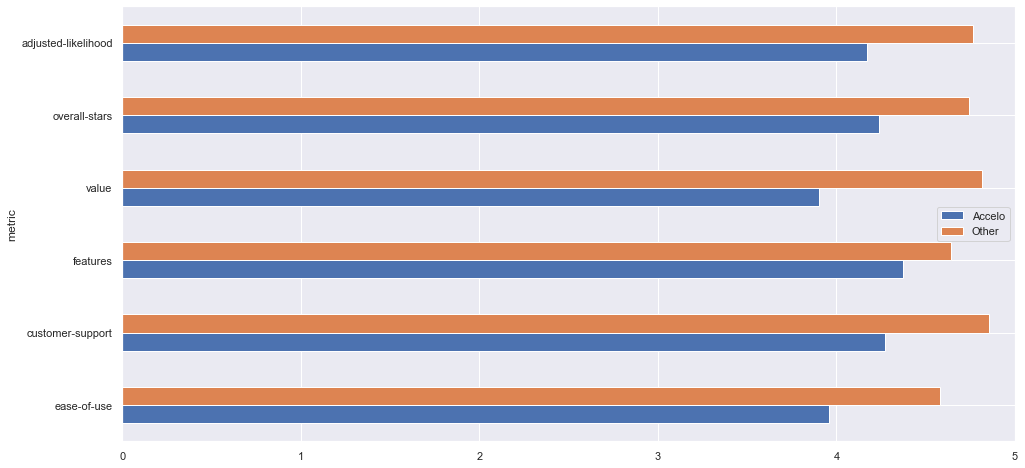

In [142]:
#@title
# Mean values (halve likelihood to match scale for other metrics)
df['temp'] = df['likelihood'].replace(r'^\s*$', np.nan, regex=True)
df['adjusted-likelihood'] = df['temp']/2
columns = ['ease-of-use','customer-support','features','value','overall-stars','adjusted-likelihood']
ac_means = df[df[IS_MAIN_COMPANY]==MAIN_COMPANY_NAME][columns].mean()
other_means = df[df[IS_MAIN_COMPANY]!=MAIN_COMPANY_NAME][columns].mean()

combined_df = pd.DataFrame(list(map(list,zip(columns,ac_means.tolist(),other_means.tolist()))),columns=["metric",MAIN_COMPANY_NAME,"Other"])
combined_df.set_index('metric', inplace=True)
combined_df.plot(kind='barh',figsize=(16,8),xlim=(0,5))

Accelo scored lower across all numeric fields. The biggest difference was for value, where the combined competitors' average score was 4.82 (/5) as opposed to Accelo's average score of 3.90:

In [144]:
#@title
print("                          " + MAIN_COMPANY_NAME + "                      Others")
print("Adjusted likelihood:       %.2f                        %.2f" % (ac_means['adjusted-likelihood'], other_means['adjusted-likelihood']))
print("Overall stars:             %.2f                        %.2f" % (ac_means['overall-stars'], other_means['overall-stars']))
print("Value:                     %.2f                        %.2f" % (ac_means['value'], other_means['value']))
print("Features:                  %.2f                        %.2f" % (ac_means['features'], other_means['features']))
print("Customer support:          %.2f                        %.2f" % (ac_means['customer-support'], other_means['customer-support']))
print("Ease of use:               %.2f                        %.2f" % (ac_means['ease-of-use'], other_means['ease-of-use']))  

                          Accelo                      Others
Adjusted likelihood:       4.17                        4.77
Overall stars:             4.24                        4.74
Value:                     3.90                        4.82
Features:                  4.38                        4.64
Customer support:          4.27                        4.85
Ease of use:               3.96                        4.58


## Metric Breakdowns: Accelo vs. GreenRope, NiceJob

Drilling down into specific strengths/weaknesses of Accelo vs. competitors GreenRope and NiceJob, the charts below report the respective company means for value, features, customer support, and ease of use.

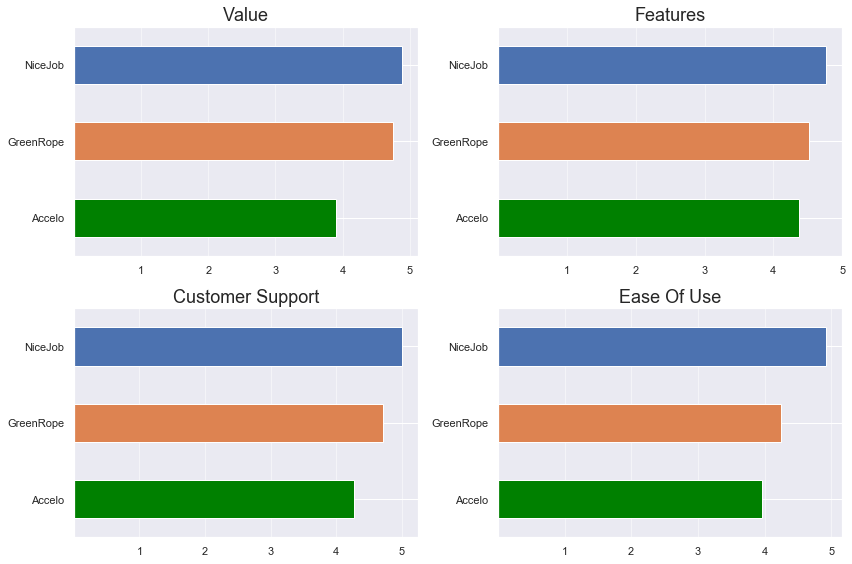

In [152]:
#@title
import matplotlib.pyplot as plt

metrics_df = df.loc[df['company'].isin([i[0] for i in companies])] # (could constrain which companies)  

gridsize = (2, 2)
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
sns.set(font_scale=1)
ax1, ax2, ax3, ax4 = ax.flatten()
my_colors = ['green', '#dd8351','#4c72b0']

ax1.set_title('Value', fontsize=18)
metrics_df.groupby(['company'])['value'].mean().plot(ax=ax1, kind='barh', color=my_colors)
ax1.set_xlabel('')
ax1.set_xticks(range(1,6))
ax1.set_ylabel('')
ax1.xaxis.grid(linestyle='-', linewidth=0.5)

ax2.set_title('Features', fontsize=18)
metrics_df.groupby(['company'])['features'].mean().plot(ax=ax2, kind='barh', color=my_colors)
ax2.set_xlabel('')
ax2.set_xticks(range(1,6))
ax2.set_ylabel('')
ax2.xaxis.grid(linestyle='-', linewidth=0.5)

ax3.set_title('Customer Support', fontsize=18)
metrics_df.groupby(['company'])['customer-support'].mean().plot(ax=ax3, kind='barh', color=my_colors)
ax3.set_xlabel('')
ax3.set_xticks(range(1,6))
ax3.set_ylabel('')
ax3.xaxis.grid(linestyle='-', linewidth=0.5)

ax4.set_title('Ease Of Use', fontsize=18)
metrics_df.groupby(['company'])['ease-of-use'].mean().plot(ax=ax4, kind='barh', color=my_colors)
ax4.set_xlabel('')
ax4.set_xticks(range(1,6))
ax4.set_ylabel('')
ax4.xaxis.grid(linestyle='-', linewidth=0.5)
fig.tight_layout()

# Rolling Means

This section shows how the means for likelihood to recommend have changed over time, using an expanding window (allowing a one-week buffer at the start of the graph).

Likelihood scores have been adjusted from (/10) to (/5) in order to align with the other numeric fields.

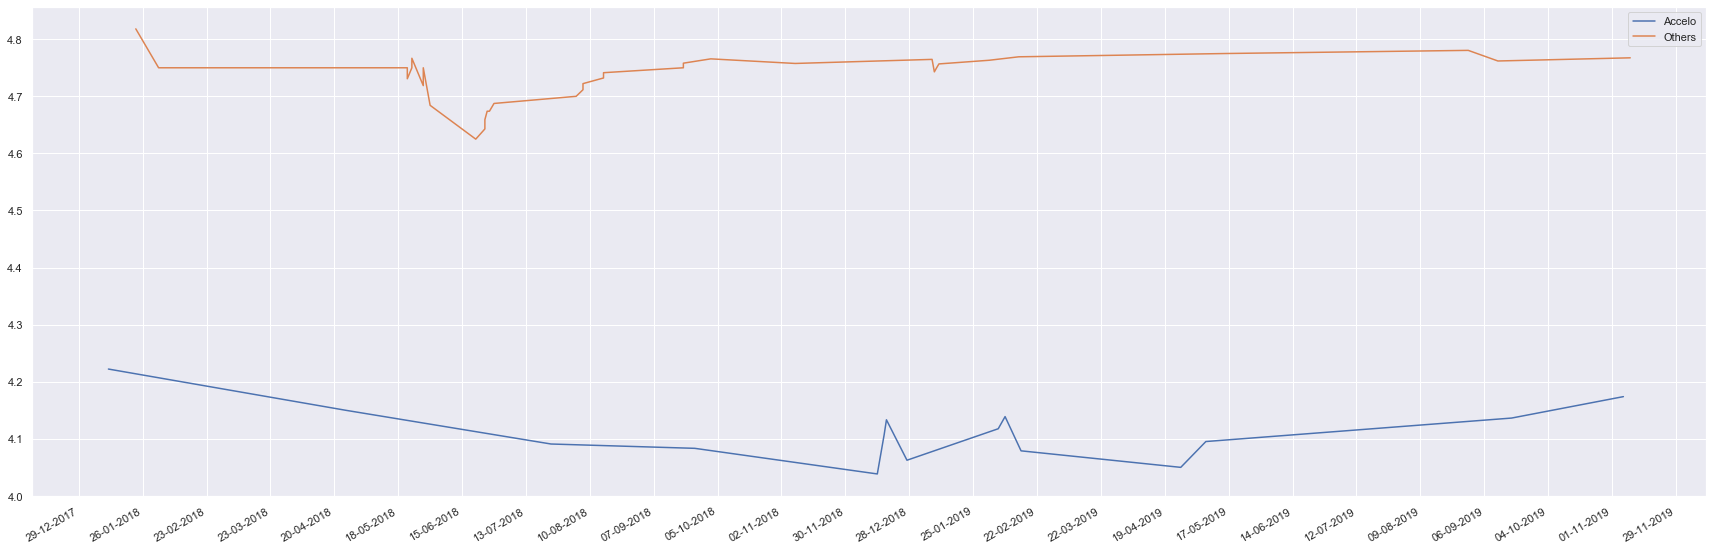

In [153]:
#@title
from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

ac_rolling_means = df[df[IS_MAIN_COMPANY] == MAIN_COMPANY_NAME].copy()
other_rolling_means = df[df[IS_MAIN_COMPANY] != MAIN_COMPANY_NAME].copy()

ac_rolling_means['adjusted-likelihood'] = ac_rolling_means['likelihood'] / 2
ac_rolling_means['adjusted-likelihood-rolling-mean'] = ac_rolling_means['adjusted-likelihood'].expanding().mean()

other_rolling_means['adjusted-likelihood'] = other_rolling_means['likelihood'] / 2
other_rolling_means['adjusted-likelihood-rolling-mean'] = other_rolling_means['adjusted-likelihood'].expanding().mean()

plt.figure(figsize=(30,10))
plt.plot('date','adjusted-likelihood-rolling-mean',data=ac_rolling_means[datetime.strptime("2018-01-01","%Y-%m-%d") <= ac_rolling_means['date']],label="Accelo")
plt.plot('date','adjusted-likelihood-rolling-mean',data=other_rolling_means[datetime.strptime("2018-01-01","%Y-%m-%d") <= other_rolling_means['date']],label="Others")
plt.legend(loc='best')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=28))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.gcf().autofmt_xdate() # Rotation
plt.show()

As can be seen above, both Accelo and GreenRope/NiceJob review ratings have remained largely steady. On average, Accelo scores consistently lower than the competitors. 

# Review Frequency By Week

Note the large spike in Accelo reviews around the end of Oct 2016:

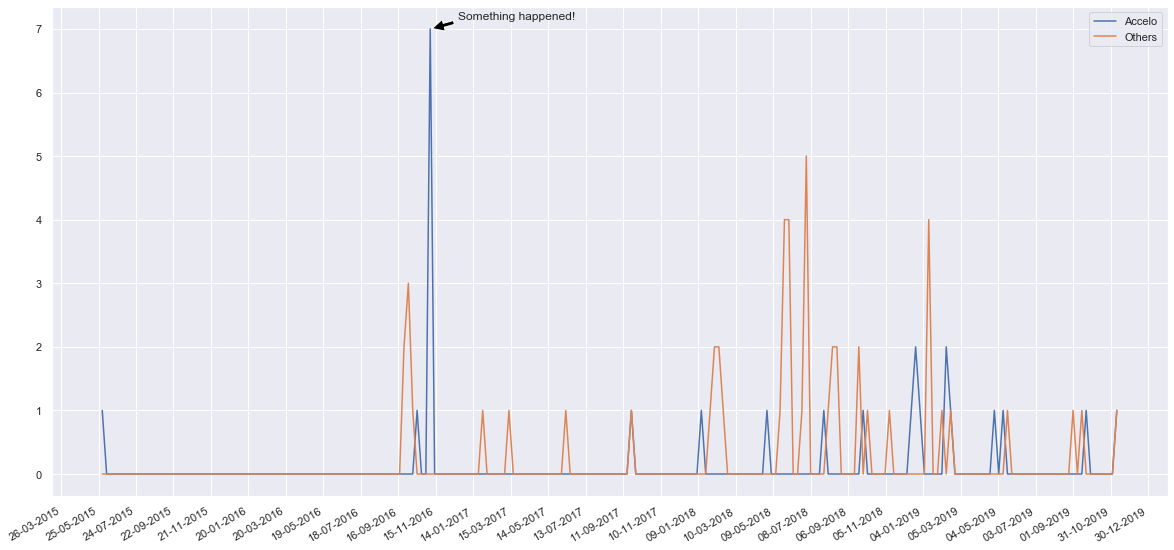

In [196]:
#@title
import matplotlib.dates as mdates

# First create empty data frame with all the weeks from the period
start = df.iloc[0]['date'] - timedelta(days=df.iloc[0]['date'].weekday())
end = df.iloc[-1]['date'] - timedelta(days=df.iloc[-1]['date'].weekday()) + timedelta(days=6)
dates = pd.date_range(start, end, freq='w')
ac_big_df = pd.DataFrame()
ac_big_df['dates'] = dates
ac_big_df.set_index('dates', inplace=True)
ac_big_df['count'] = 0

other_big_df = ac_big_df.copy()

# Loop through the data and populate the number of reviews for each week
for index, row in df.iterrows():
    end_of_week = row['date'] - timedelta(days=row['date'].weekday()) + timedelta(days=6)
    if row[IS_MAIN_COMPANY] == MAIN_COMPANY_NAME:
        ac_big_df.loc[end_of_week.strftime("%Y-%m-%d")]['count'] += 1
    else:
        other_big_df.loc[end_of_week.strftime("%Y-%m-%d")]['count'] += 1

plt.figure(figsize=(20,10))
plt.plot(ac_big_df.index,ac_big_df['count'],label=MAIN_COMPANY_NAME)
plt.plot(other_big_df.index,other_big_df['count'],label="Others")
plt.legend(loc='best')

plt.annotate('Something happened!', xy=("2016-11-07", 7), 
             xytext=("2016-12-20", 7.15), 
             arrowprops=dict(facecolor='black', shrink=0.05)
            )

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=60))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.gcf().autofmt_xdate() # Rotation
plt.show()

# Correlations

The fact that we have data points about several different aspects of reviewers' experiences with Accelo and competitors, as well as their overall likelihood to recommend, gives us a fascinating insight into what users value most.

The chart below shows correlations between the numeric responses in the Accelo data: ease of use, customer support, features, value, overall rating, and likelihood to recommend. For example, there was a fairly strong positive correlation of 0.77 between customer support and ease of use - note that all of these correlations are positive.

Of particular note are the correlations between likelihood to recommend and the most granular metrics of ease of use, customer support, features, and value. Which of those four granular metrics would have the strongest relationship with a customer's likelihood to recommend?

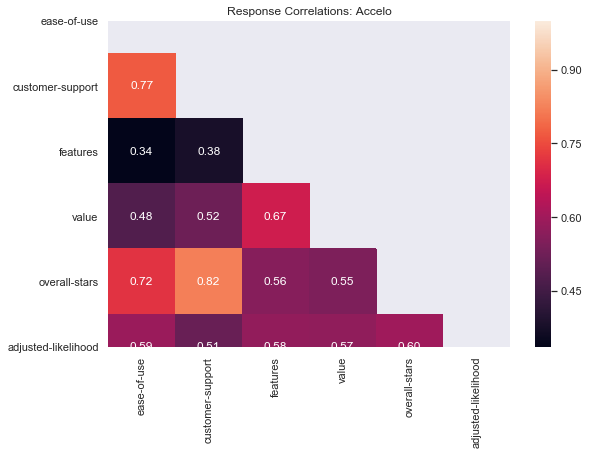

In [169]:
#@title
import seaborn as sns
import numpy as np

def do_correlations(corr_df, title):
    corr = corr_df[['ease-of-use','customer-support','features','value','overall-stars','adjusted-likelihood']].corr()
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    sns.set(rc={'figure.figsize':(9,6)})
    sns.heatmap(corr, 
                xticklabels=corr.columns.values,
                yticklabels=corr.columns.values,
                annot=True,
                fmt=".2f",
                mask=mask).set(title=title)
    
ac_df = df[df[IS_MAIN_COMPANY]==MAIN_COMPANY_NAME]
do_correlations(ac_df, "Response Correlations: " + MAIN_COMPANY_NAME)

# 15/12/2019, currently a formatting error in Seaborn - https://github.com/mwaskom/seaborn/issues/1773

In fact, the metric with the highest correlation to likelihood to recommend for Accelo reviews was <b>overall-stars</b>, at <b>0.60</b>. <b>Customer support</b> was the least significant predictor of likelihood to recommend, at <b>0.51</b>.

These are the response correlations for the others:

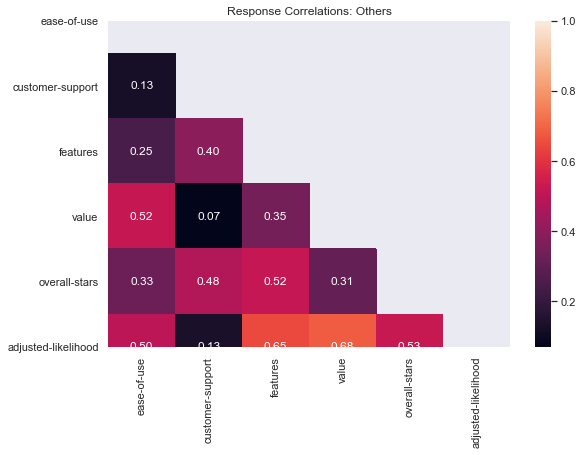

In [170]:
#@title
other_df = df[df[IS_MAIN_COMPANY]!=MAIN_COMPANY_NAME]
do_correlations(other_df, "Response Correlations: Others")

For competitors, <b>value</b> was the strongest predictor of likelihood to recommend at <b>0.68</b>.

The weakest correlation with likelihood to recommend was also <b>customer support</b>, at <b>0.13</b>.

# Language in Responses

## Word Counts

For each of the free-text fields ('title', 'comments', 'pros', and 'cons'), what were the most common words in reviewer responses?

Common 'stopwords' (i.e. "the", "and", "to" etc.) have been removed, as well as brand-specific references.

First, here are the most common words for Accelo reviews:

In [172]:
#@title
!pip install -q nltk

In [173]:
#@title
import nltk

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /Users/sam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/sam/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/sam/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/sam/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [174]:
#@title
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import string

def get_words(series, extra_stop=[]):
    # Remove any stop words and remaining punctuation
    stop = set(stopwords.words('english') + \
           ["accelo","greenrope","nicejob"] + extra_stop)    
    words = [i.translate(str.maketrans('', '', string.punctuation)) for i in ' '.join(series).lower().split() if i not in stop]
    
    # Reduce to lemmas, see https://www.datacamp.com/community/tutorials/stemming-lemmatization-python
    wordnet_lemmatizer = WordNetLemmatizer()
    return [wordnet_lemmatizer.lemmatize(i, get_wordnet_pos(i)) for i in words if i]

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""

    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def get_frequency_table(title_words, comments_words, pros_words, cons_words):
    series = pd.Series(title_words).value_counts()[:15]
    titles = series.rename_axis('title_words').to_frame('title_counts').reset_index()
    
    series = pd.Series(comments_words).value_counts()[:15]
    comments = series.rename_axis('comments_words').to_frame('comments_counts').reset_index()
    
    series = pd.Series(pros_words).value_counts()[:15]
    pros = series.rename_axis('pros_words').to_frame('pros_counts').reset_index()
    
    series = pd.Series(cons_words).value_counts()[:15]
    cons = series.rename_axis('cons_words').to_frame('cons_counts').reset_index()

    # Make a data frame with most common words for each free-text field
    text_df = pd.DataFrame()
    text_df = titles.join(comments, how='outer').join(pros, how='outer').join(cons, how='outer')
    return text_df
  
def find_and_print_reviews(company, search_term, field):
    # TODO - accept multiple fields etc.
    t = df[(df[field].str.contains(search_term)) & (df['company']==company)]
    for index, row in t.iterrows():
        print("%s: %s" % (row['company'],row[field]))
  
# For each of the free-text fields, get the most common words in reviewers' responses  
ac_title_words = get_words(ac_df['title'])
ac_comments_words = get_words(ac_df['comments'])
ac_pros_words = get_words(ac_df['pros'])
ac_cons_words = get_words(ac_df['cons'])
    
print("Word Counts: Accelo")
print("===================")
ac_text_df = get_frequency_table(ac_title_words, ac_comments_words, ac_pros_words, ac_cons_words)
ac_text_df

Word Counts: Accelo


,title_words,title_counts,comments_words,comments_counts,pros_words,pros_counts,cons_words,cons_counts
0,management,5,work,12,project,20,time,12
1,tool,4,business,9,u,10,need,9
2,lot,3,client,7,time,10,day,9
3,crm,3,use,6,use,8,company,8
4,excellent,3,project,6,track,7,use,7
5,agency,3,team,5,business,7,work,6
6,business,3,platform,5,client,6,view,6
7,project,3,system,5,task,6,like,6
8,process,2,help,5,love,5,take,6
9,easy,2,sale,5,also,5,1,6


As shown above, many terms in Accelo reviews related to features.

Following are the word counts for competitor reviews:

In [175]:
#@title
# For each of the free-text fields, get the most common words in reviewers' responses  
other_title_words = get_words(other_df['title'], extra_stop=["insight","gps"])
other_comments_words = get_words(other_df['comments'], extra_stop=["insight","gps"])
other_pros_words = get_words(other_df['pros'], extra_stop=["insight","gps"])
other_cons_words = get_words(other_df['cons'], extra_stop=["insight","gps"])

print("Word Counts: Others")
print("===================")
other_text_df = get_frequency_table(other_title_words, other_comments_words, other_pros_words, other_cons_words)
other_text_df

Word Counts: Others


,title_words,title_counts,comments_words,comments_counts,pros_words,pros_counts,cons_words,cons_counts
0,great,11,review,17,use,23,like,14
1,best,6,customer,15,easy,18,use,13
2,review,5,make,15,review,17,email,10
3,business,5,business,14,work,16,work,10
4,software,4,easy,12,make,15,easy,9
5,customer,4,use,12,customer,11,customer,9
6,marketing,4,get,10,ability,11,nothing,8
7,well,4,website,10,software,11,feature,7
8,crm,4,one,10,email,10,new,7
9,year,4,marketing,9,well,10,review,7


Use the code block below to find specific reviews (you will need to load the data first, as per the "Load Data" section).

In [176]:
#@title
# To find specific reviews, enter company, fieldname, and search term below
company = MAIN_COMPANY_NAME
search_term = "nice"
field = "comments" # title, comments, pros, or cons
find_and_print_reviews(company, search_term, field)

Accelo: Accelo is one of the most systematic and organized application. I opted for the free trial and was very much pleased with what it offered. It a system or strategy that helped me managing client interactions, dealing with future and current customers, optimizing and systematizing relationships between them. It is a cloud-based CRM platform, which allows me to stay connected with the client information whenever and from wherever. All the requirements to satisfy a client could be done online through the AffinityLive application. It also integrates nicely with other applications such as Google related applications (Google Mail, Contacts, and Calendar). The user interface is easy to use and navigate. Glad I came across it. I am so relieved all the work is done easily with this.


## Bigrams (Word Pairs)

What were the most common pairs of words across the different text fields, firstly for Accelo reviews and secondly for competitor reviews?

In [177]:
#@title
import nltk
import operator

# Compute frequency distribution for all the bigrams in the text
# (Remember that stopwords + brand references have already been removed by this stage)
def print_bigrams(title_words, comments_words, pros_words, cons_words):
    bgs = nltk.bigrams(title_words)
    fdist = nltk.FreqDist(bgs)
    titles = sorted(fdist.items(), key=operator.itemgetter(1), reverse=True)[:15]
    bgs = nltk.bigrams(comments_words)
    fdist = nltk.FreqDist(bgs)
    comments = sorted(fdist.items(), key=operator.itemgetter(1), reverse=True)[:15]
    bgs = nltk.bigrams(pros_words)
    fdist = nltk.FreqDist(bgs)
    pros = sorted(fdist.items(), key=operator.itemgetter(1), reverse=True)[:15]
    bgs = nltk.bigrams(cons_words)
    fdist = nltk.FreqDist(bgs)
    cons = sorted(fdist.items(), key=operator.itemgetter(1), reverse=True)[:15]

    print("Titles                         Comments                       Pros                           Cons\n")
    for i in range(0,15):
        title = "(" + titles[i][0][0] + ", " + titles[i][0][1] + "), " + str(titles[i][1])
        comment = "(" + comments[i][0][0] + ", " + comments[i][0][1] + "), " + str(comments[i][1])
        pro = "(" + pros[i][0][0] + ", " + pros[i][0][1] + "), " + str(pros[i][1])
        con = "(" + cons[i][0][0] + ", " + cons[i][0][1] + "), " + str(cons[i][1])
        print("%-30s %-30s %-30s %-30s" % (title,comment,pro,con))
        
print("Word Pairs for Accelo")
print("=====================\n")
print_bigrams(ac_title_words, ac_comments_words, ac_pros_words, ac_cons_words)

Word Pairs for Accelo

Titles                         Comments                       Pros                           Cons

(project, management), 3       (help, manage), 2              (project, management), 3       (schedule, view), 5           
(management, tool), 2          (business, grow), 2            (allows, u), 3                 (learn, curve), 3             
(marketing, agency), 2         (ongoing, work), 2             (one, place), 2                (feel, like), 3               
(easy, learn), 1               (application, google), 2       (crm, sale), 2                 (take, time), 2               
(learn, helpful), 1            (pro, first), 1                (use, accelo), 2               (within, accelo), 2           
(helpful, staff), 1            (first, reason), 1             (project, template), 2         (quickbooks, online), 2       
(staff, run), 1                (reason, chose), 1             (extremely, helpful), 2        (much, else), 2               
(run, away

In [178]:
#@title
print("Word Pairs for Others")
print("=====================\n")
print_bigrams(other_title_words, other_comments_words, other_pros_words, other_cons_words)

Word Pairs for Others

Titles                         Comments                       Pros                           Cons

(customer, service), 4         (5, star), 5                   (easy, use), 7                 (feel, like), 4               
(great, software), 3           (social, medium), 4            (ease, use), 4                 (leave, review), 3            
(great, customer), 2           (customer, service), 4         (customer, service), 4         (feature, feel), 2            
(small, business), 2           (nice, job), 4                 (one, place), 3                (learn, curve), 2             
(business, great), 2           (ease, use), 3                 (make, sure), 3                (easy, use), 2                
(help, u), 1                   (one, place), 3                (work, well), 3                (like, need), 2               
(u, book), 1                   (email, marketing), 2          (email, marketing), 3          (basic, feature), 2           
(book, rev

## Bigrams with "Not"

Some words that sound positive are actually negative if preceded by "not" (or vice versa). 

What were the most common word pairs (bigrams) for Accelo and competitiors where the the first word in the pair was "not"?

In [179]:
#@title
# (Need to use unstopped words so that "not" is included)
def get_not_bigrams(text_df):
    unstopped_words = [i for i in ' '.join(text_df['title']+text_df['comments']+text_df['pros']+text_df['cons']).lower().split()]
    bgs = nltk.bigrams(unstopped_words)
    fdist = nltk.FreqDist(bgs)
    return [((a,b),c) for ((a,b),c) in fdist.items() if a == 'not']
    
not_bigrams = get_not_bigrams(ac_df)
print("Word Pairs with \"Not\" for Accelo")
print("================================")
sorted(not_bigrams, key=operator.itemgetter(1), reverse=True)[:10]

Word Pairs with "Not" for Accelo


[(('not', 'much'), 2),
 (('not', 'great'), 1),
 (('not', 'only'), 1),
 (('not', 'be'), 1),
 (('not', 'user'), 1),
 (('not', 'populate....'), 1),
 (('not', 'so'), 1),
 (('not', 'set'), 1),
 (('not', 'for'), 1),
 (('not', 'have'), 1)]

In [180]:
#@title
not_bigrams = get_not_bigrams(other_df)
print("Word Pairs with \"Not\" for Others")
print("================================")
sorted(not_bigrams, key=operator.itemgetter(1), reverse=True)[:10]

Word Pairs with "Not" for Others


[(('not', 'as'), 3),
 (('not', 'had'), 1),
 (('not', 'exactly'), 1),
 (('not', 'look'), 1),
 (('not', 'smart!!!'), 1),
 (('not', 'highlight'), 1),
 (('not', 'being'), 1),
 (('not', 'doing'), 1),
 (('not', 'send'), 1),
 (('not', 'able'), 1)]

## Trigrams

What were the most common sets of three words (trigrams) that occur together in Accelo/competitor reviews?

In [181]:
#@title
bgs = nltk.trigrams(ac_title_words + ac_comments_words + ac_pros_words + ac_cons_words)
fdist = nltk.FreqDist(bgs)
print("Word Trios for Accelo")
print("=====================")
sorted(fdist.items(), key=operator.itemgetter(1), reverse=True)[:15]

Word Trios for Accelo


[(('project', 'management', 'tool'), 2),
 (('time', 'online', 'tool'), 2),
 (('online', 'tool', 'come'), 2),
 (('tool', 'come', 'box'), 2),
 (('come', 'box', 'ready'), 2),
 (('box', 'ready', 'run'), 2),
 (('ready', 'run', 'play'), 2),
 (('run', 'play', 'also'), 2),
 (('play', 'also', 'allows'), 2),
 (('also', 'allows', 'business'), 2),
 (('allows', 'business', 'customize'), 2),
 (('business', 'customize', 'workflow'), 2),
 (('customize', 'workflow', 'project'), 2),
 (('workflow', 'project', 'skeleton'), 2),
 (('project', 'skeleton', 'shape'), 2)]

In [182]:
#@title
bgs = nltk.trigrams(other_title_words + other_comments_words + other_pros_words + other_cons_words)
fdist = nltk.FreqDist(bgs)
print("Word Trios for Others")
print("=====================")
sorted(fdist.items(), key=operator.itemgetter(1), reverse=True)[:15]

Word Trios for Others


[(('last', '3', 'year'), 2),
 (('3', 'year', 'combine'), 2),
 (('great', 'customer', 'service'), 2),
 (('send', 'automate', 'email'), 2),
 (('excellent', 'response', 'time'), 2),
 (('feel', 'like', 'lot'), 2),
 (('get', 'job', 'do'), 2),
 (('everything', 'one', 'place'), 2),
 (('review', 'management', 'software'), 2),
 (('5', 'star', 'business'), 2),
 (('great', 'work', 'with'), 2),
 (('website', 'look', 'great'), 2),
 (('look', 'great', 'easy'), 2),
 (('software', 'easy', 'use'), 2),
 (('feature', 'feel', 'like'), 2)]

## Sentiment Analysis

Using sentiment analysis, it is possible to rate each review according to how positive/negative the content of its text is - e.g. this technique is also often applied to analysing the tone of social media comments.

The package used for this analysis is Vader, described on http://t-redactyl.io/blog/2017/04/using-vader-to-handle-sentiment-analysis-with-social-media-text.html.

In [183]:
#@title
!pip install vaderSentiment

In [184]:
#@title
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk import tokenize

analyser = SentimentIntensityAnalyzer()

# Add empty column
df['vader_compound'] = 0.0

# Loops through each row
for index, row in df.iterrows():       
    compounds = []
    
    # Break up each text field in the row into sentences and take sentiment score for each
    for (field, weight) in [('title',3),('comments',1),('pros',1),('cons',2)]:
        lines_list = tokenize.sent_tokenize(df.iloc[index][field])
        for sentence in lines_list:
            score = analyser.polarity_scores(sentence)['compound']
            
            # Count 'title' and 'cons' scores multiple times in order to increase weight for these fields
            for i in range(1, weight):
                compounds.append(score)    
            
    # Take average sentiment score for row        
    df['vader_compound'].at[index] = sum(compounds)/len(compounds)

In this case we give extra weight to the sentiment scores for 'title' (3x) and 'cons' (2x) in each review, as these appear to be most indicative fields of the overall tone.

## Positive Reviews

Having calculated the sentiment scores, what were some of the most positive reviews for Accelo?

In [185]:
#@title
def print_sentiments(df, i):
    print("Title: " + df.iloc[i]['title'])
    print("Sentiment Analysis Score: " + str(df.iloc[i]['vader_compound']))
    print("Company: " + df.iloc[i]['company'])
    print("Comments: " + df.iloc[i]['comments'])
    print("Pros: " + df.iloc[i]['pros'])
    print("Cons: " + df.iloc[i]['cons'])
    print("Overall Stars: " + str(df.iloc[i]['overall-stars']))
    print('')

vader_pos_df = df[df[IS_MAIN_COMPANY]==MAIN_COMPANY_NAME].sort_values(by='vader_compound', ascending=False)[:5]
for i, row in vader_pos_df.iterrows():
    print_sentiments(df, i)

Title: Ongoing clever innovation keeps this product fresh
Sentiment Analysis Score: 0.7744333333333332
Company: Accelo
Comments: Accelo solves the problem of double handling data when progressing clients from sales to work in progress and maintaining ongoing work for that client. This saves time and cost... In the past we had to re-enter the contact details from a CRM, after the lead became a client, into a Project Management system, for service delivery, then into a Support tool, to manage ongoing work. A single license with Accelo was cheaper, than other software systems combined.
Pros: I like that Accelo combines almost all facets of my business in one application. Not only do I get CRM & sales capability, I also get job/task tracking, project management, support ticketing, and billing! There is integration with key third party apps so I rarely have to go anywhere else to run the business.
Cons: It is hard to dislike anything given all the recent improvements, but next I'd like to s

And for the competitors:

In [186]:
#@title
vader_pos_df = df[df[IS_MAIN_COMPANY]!=MAIN_COMPANY_NAME].sort_values(by='vader_compound', ascending=False)[:5]
for i, row in vader_pos_df.iterrows():
    print_sentiments(df, i)

Title: Great software and great customer service
Sentiment Analysis Score: 0.63215
Company: NiceJob
Comments: It is very cool to see a company that cares about it customers like nicejob does
Pros: How easy it is to use. The results are of the charts with the convert website and the ability of nicejob to get reviews.
Cons: nothing i don't like so far. It is a great product
Overall Stars: 5

Title: This is a Great marketing platform
Sentiment Analysis Score: 0.6249
Company: NiceJob
Comments: My old website cost nearly $ and then a monthly fee to have SEO and it did not look as good as my NiceJob site and barely produced any inbound customer requests. I've had the  NiceJob marketing platform for about 2 years now and from day one it blew the doors off my old site as far as customer leads, it looks 10 times more professional and it also makes staying on top of social media almost effortless. To say that I am Super Impressed would be an understatement. I highly recommend the NiceJob marketi

## Negative Reviews

On the other hand, what were some of the most negative reviews for Accelo?

In [187]:
#@title
vader_neg_df = df[df[IS_MAIN_COMPANY]==MAIN_COMPANY_NAME].sort_values(by='vader_compound', ascending=True)[:5]
for i, row in vader_neg_df.iterrows():
    print_sentiments(df, i)

Title: Customized Agency CRM with lots of ongoing Changes but might not be best fit
Sentiment Analysis Score: -0.5352666666666667
Company: Accelo
Comments: ordering and keeping track of our client base - with specific notes and stream or history of conversations and emails with each of them attached.
Pros: We transitioned away from an Excel Spreadsheet to Accelo and the transition was amazing. Just forcing us to cleanup our accounts in order to transition saved us thousands in internal errors, missed billing etc.
Cons: Our biggest issues with Accelo were integration and Price: 
Overall Stars: 4

Title: Run away! Terrible quality updates and the worst customer service. False advertising of integrations
Sentiment Analysis Score: -0.26733333333333337
Company: Accelo
Comments: The first reason we chose AffinityLive, now Accelo due to what was a great set of tutorials and video demos.
Pros: 
Cons: 
Overall Stars: 2

Title: Lots of Potential
Sentiment Analysis Score: -0.182025
Company: Accel

And for the competitors:

In [188]:
#@title
vader_neg_df = df[df[IS_MAIN_COMPANY]!=MAIN_COMPANY_NAME].sort_values(by='vader_compound', ascending=True)[:5]
for i, row in vader_neg_df.iterrows():
    print_sentiments(df, i)

Title: The Greenrope Team ROCKS!
Sentiment Analysis Score: -0.23343333333333335
Company: GreenRope
Comments: VERY POSITIVE. The best part about this is the support team behind the software. I am new to GR so it is so CLUTCH having a team  to reach out to when I am stuck in the mud. They have each helped me at various stages in implementing marketing funnels for my client. They are very responsive and I can always count on them to help me get things to the finish line. You guys make me look good! Thank you very much for your help and support. You guys rock!
Pros: A ton, the organization of elements, I also like how user friendly it is to jump from section to section. 
Cons: Nothing, I am new to GR so alot of my problems are more about me being new to it, than anything wrong with the software....
Overall Stars: 5

Title: From 20 to 130 reviews in just a few months! And our social media marketing had never looked better.
Sentiment Analysis Score: -0.16676666666666665
Company: NiceJob
Comm

## Comparison: Accelo vs. Competitors

So, how did the sentiment scores for Accelo compare to the scores for the competitors?

In [194]:
#@title
main_company_mean = df[df['company']==MAIN_COMPANY_NAME]['vader_compound'].mean()
print("Mean sentiment score for " + MAIN_COMPANY_NAME + ": %.2f" % main_company_mean)
other_mean = df[df['company']!=MAIN_COMPANY_NAME]['vader_compound'].mean()
print("Mean sentiment score for Others: %.2f" % other_mean)

Mean sentiment score for Accelo: 0.19
Mean sentiment score for Others: 0.26


Competitors have a mean sentiment score (can range from -1 to 1) of 0.26, as opposed to Accelo of 0.19, which is mildly positive.

## Analysis Accuracy

So, how did the sentiment analysis perform? One way to measure this is to compare the sentiment scores for each review to their overall rating out of 5, which is also part of the data for each review, to see if this indicates a positive relationship.

Below is a scatter plot of overall rating (from 1 to 5) vs. sentiment score (from -1 to 1).

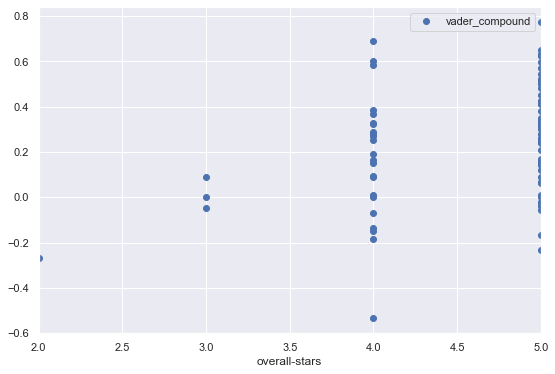

In [190]:
#@title
df.plot(x='overall-stars', y='vader_compound', style='o')

As you can see, as the overall rating increases, so does the sentiment score, which indicates a positive relationship.

Or, viewed another way, let's take the mean sentiment score for each overall rating from 1 to 5, and then plot a line of best fit:

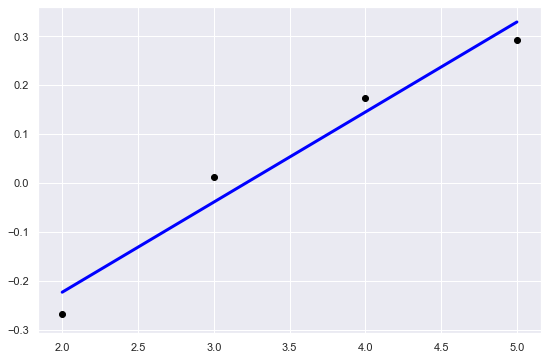

In [191]:
#@title
import numpy as np
from sklearn import datasets, linear_model
import matplotlib.pyplot as plt

ratings = []
means = []
for i in range(1,6):
    if len(df[df['overall-stars'] == i]) > 0:
        ratings.append(i)
        means.append(df[df['overall-stars'] == i]['vader_compound'].mean())

regr = linear_model.LinearRegression()
x = np.array(ratings).reshape(-1,1)
y = np.array(means)
regr.fit(x, y)

# Plot it as in the example at http://scikit-learn.org/
plt.scatter(x, y,  color='black')
plt.plot(x, regr.predict(x), color='blue', linewidth=3)
plt.show()

In [192]:
#@title
from sklearn.metrics import mean_squared_error, r2_score

y_predicted = regr.predict(x)
rmse = mean_squared_error(y, y_predicted)
r2 = r2_score(y, y_predicted)
r2

0.9610008074860004

As can be seen above, the line of best fit is a close match to the actual values, which suggests that the sentiment analysis performs well.

The R<sup>2</sup> value for the regression line is 0.96 (on a scale from -1 to 1), which is very high.

This means that we can confidently apply sentiment analysis to text even when no numeric ratings data is present to test against, e.g. on social media sites.

# Summary

This analysis has given a brief overview of data from Accelo/competitor reviews on Capterra, which could easily be extended to other companies/data sets.

In summary, we have shown:

* Examples of data wrangling and cleaning, including filling in missing values

* How to use descriptive statistics/boxplots and summary statistics to compare different data sets

* How to find correlations between numeric values, and to present these is an aesthetically pleasing way

* How to show a aggregated event frequencies as a line graph

* An application of textual analysis, including word frequences, bigrams, and trigrams

* An application of sentiment analysis using Vader, and a quantitiative confirmation of its accuracy 

It would be valuable to continue repeating this study as more reviews are submitted to determine if these trends change or remain constant.